In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM

In [ ]:
%matplotlib inline

In [ ]:
global_seed = 42
np.random.seed(global_seed)

main_path = "/content/gdrive/My Drive/Remote LSTM"
datasets = ["LostCreek_MI_DailyData", "NE3_DailyData", "TonziRanch_CA_DailyData", "WalnutGulchWatershed_AZ_DailyData"]

In [ ]:
select = 1

file_path = datasets[select]

In [ ]:
trained_models = ["model_lstm_LostCreek_MI_DailyData_2020-12-24 03:00:18",
                  "model_lstm_NE3_DailyData_2020-12-24 02:24:04",
                  "model_lstm_TonziRanch_CA_DailyData_2020-12-24 00:36:21",
                  "model_lstm_WalnutGulchWatershed_AZ_DailyData_2020-12-24 01:37:36"]

saved_model = trained_models[select]

In [ ]:
def normalize(x, mode="minmax", a=None, b=None):
    if mode == "minmax":
        # Min-max [0, 1]
        return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    if mode == "mean":
        # Mean normalization
        return (x - x.mean(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    if mode == "custom":
        # Custom range [a, b]
        return a + ((x - x.min(axis=0)) * (b - a)) / (x.max(axis=0) - x.min(axis=0))

In [ ]:
df = pd.read_excel(f"{main_path}/Data Daily/{file_path}.xlsx")
df = df.set_index("Date")
data = normalize(df)

In [ ]:
data

,LE (W/m2)
Date,
2001-06-13,0.188596
2001-06-14,0.434084
2001-06-15,0.517753
2001-06-16,0.304140
2001-06-17,0.250497
...,...
2014-12-27,0.078525
2014-12-28,0.061284
2014-12-29,0.052193


In [ ]:
def timeshift(data, timesteps=1, forecasts=1):
    df = pd.DataFrame(data)
    shifted = [df.shift(i) for i in range(timesteps, - forecasts, -1)]
    ts = pd.concat(shifted, axis=1)
    ts.columns = [f"t{1 - i}" for i in range(timesteps + 1, 1 - forecasts, -1)]
    ts.fillna(0, inplace=True)
    return ts

In [ ]:
timesteps = 100
features = 1
forecasts = 1

ts_data = timeshift(data["LE (W/m2)"], timesteps, forecasts)

In [ ]:
ts_data

,t-100,t-99,t-98,t-97,t-96,t-95,t-94,t-93,t-92,t-91,t-90,t-89,t-88,t-87,t-86,t-85,t-84,t-83,t-82,t-81,t-80,t-79,t-78,t-77,t-76,t-75,t-74,t-73,t-72,t-71,t-70,t-69,t-68,t-67,t-66,t-65,t-64,t-63,t-62,t-61,...,t-39,t-38,t-37,t-36,t-35,t-34,t-33,t-32,t-31,t-30,t-29,t-28,t-27,t-26,t-25,t-24,t-23,t-22,t-21,t-20,t-19,t-18,t-17,t-16,t-15,t-14,t-13,t-12,t-11,t-10,t-9,t-8,t-7,t-6,t-5,t-4,t-3,t-2,t-1,t0
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-06-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188596
2001-06-14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188596,0.434084
2001-06-15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188596,0.434084,0.517753
2001-06-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.188596,0.434084,0.517753,0.304140
2001-06-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [ ]:
if select == 0:
    data_train = ts_data["2001":"2018"]
    data_test = ts_data["2019":]
elif select == 1:
    data_train = ts_data["2002":"2013"]
    data_test = ts_data["2014":]
elif select == 2:
    data_train = ts_data["2002":"2018"]
    data_test = ts_data["2019":]
elif select == 3:
    data_train = ts_data["2010":"2018"]
    data_test = ts_data["2019":]
else:
    raise Exception("error")

In [ ]:
x_train = data_train.iloc[:, :-forecasts].to_numpy()
x_test = data_test.iloc[:, :-forecasts].to_numpy()

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

y_train = data_train.iloc[:, -forecasts:].to_numpy()
y_test = data_test.iloc[:, -forecasts:].to_numpy()

In [ ]:
def network(vector_dim, cast):
    input = Input(shape=vector_dim)

    rnn1 = LSTM(400, return_sequences=True)(input)
    drp1 = Dropout(0.05)(rnn1)

    rnn2 = LSTM(400)(drp1)
    drp2 = Dropout(0.05)(rnn2)

    output = Dense(cast)(drp2)

    model = tf.keras.Model(inputs=[input], outputs=[output])
    model.compile(optimizer="adam", loss="mean_squared_error")

    return model

In [ ]:
load_saved = False
retrain = False

In [ ]:
if load_saved:
    model = tf.keras.models.load_model(f"{main_path}/models/{saved_model}")
else:
    model = network((timesteps, features), 1)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 400)          643200    
_________________________________________________________________
dropout (Dropout)            (None, 100, 400)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 401       
Total params: 1,925,201
Trainable params: 1,925,201
Non-trainable params: 0
___________________________________________________

In [ ]:
if load_saved:
    if retrain:
        model.fit(x_train, y_train, epochs=500, batch_size=16, verbose=2)
    else:
        print("Skipping training")
else:
    model.fit(x_train, y_train, epochs=500, batch_size=16, verbose=2)

Skipping training


In [ ]:
if load_saved:
    if retrain:
        model.save(f"{main_path}/models/model_lstm_{file_path}_{str(datetime.datetime.now())[:-7]}")
    else:
        print("Not saved")
else:
    model.save(f"{main_path}/models/model_lstm_{file_path}_{str(datetime.datetime.now())[:-7]}")

Not saved


In [ ]:
future = 365

In [ ]:
x = np.concatenate((x_train, x_test), axis=0)
preds = []

for _ in range(future):
    p = model.predict(x)
    box = np.reshape(p, (p.shape[0], 1, 1))
    temp = x[:, 1:]
    x = np.concatenate((temp, box), axis=1)
    preds.append(p)

In [ ]:
preds = np.array(preds)

In [ ]:
apple = np.reshape(preds, (preds.shape[0], preds.shape[1]))
apple = apple.T
formated_pred = pd.DataFrame(apple, columns=[f"{i + 1} day forecast" for i in range(future)])

In [ ]:
formated_pred

,1 day forecast,2 day forecast,3 day forecast,4 day forecast,5 day forecast,6 day forecast,7 day forecast,8 day forecast,9 day forecast,10 day forecast,11 day forecast,12 day forecast,13 day forecast,14 day forecast,15 day forecast,16 day forecast,17 day forecast,18 day forecast,19 day forecast,20 day forecast,21 day forecast,22 day forecast,23 day forecast,24 day forecast,25 day forecast,26 day forecast,27 day forecast,28 day forecast,29 day forecast,30 day forecast,31 day forecast,32 day forecast,33 day forecast,34 day forecast,35 day forecast,36 day forecast,37 day forecast,38 day forecast,39 day forecast,40 day forecast,...,326 day forecast,327 day forecast,328 day forecast,329 day forecast,330 day forecast,331 day forecast,332 day forecast,333 day forecast,334 day forecast,335 day forecast,336 day forecast,337 day forecast,338 day forecast,339 day forecast,340 day forecast,341 day forecast,342 day forecast,343 day forecast,344 day forecast,345 day forecast,346 day forecast,347 day forecast,348 day forecast,349 day forecast,350 day forecast,351 day forecast,352 day forecast,353 day forecast,354 day forecast,355 day forecast,356 day forecast,357 day forecast,358 day forecast,359 day forecast,360 day forecast,361 day forecast,362 day forecast,363 day forecast,364 day forecast,365 day forecast
0,0.011829,0.011257,0.013185,0.017211,0.013884,0.015389,0.016264,0.012020,0.011466,0.013331,0.013172,0.011017,0.012088,0.011860,0.011755,0.010836,0.011266,0.010296,0.011058,0.011462,0.011430,0.011274,0.012046,0.012221,0.011890,0.011956,0.012234,0.012017,0.011599,0.011766,0.011423,0.011465,0.011535,0.011790,0.011455,0.011119,0.011567,0.011734,0.011717,0.011852,...,0.021011,0.023706,0.017724,0.012433,0.012783,0.013684,0.015386,0.017638,0.013372,0.011950,0.014174,0.017245,0.020326,0.019018,0.018577,0.019229,0.021796,0.025551,0.028166,0.030196,0.027697,0.021087,0.017900,0.018667,0.019000,0.020860,0.021690,0.016591,0.014336,0.014387,0.012908,0.013760,0.014771,0.013185,0.014308,0.017211,0.019967,0.021041,0.018419,0.017156
1,0.009527,0.012001,0.016230,0.012549,0.014992,0.015587,0.010891,0.011459,0.013341,0.013013,0.010866,0.012101,0.010819,0.011288,0.011061,0.011095,0.009895,0.011032,0.011457,0.011454,0.011141,0.011937,0.011915,0.011655,0.011845,0.012238,0.011922,0.011604,0.011729,0.011372,0.011421,0.011634,0.011788,0.011429,0.010907,0.011498,0.011647,0.011687,0.011826,0.012059,...,0.023795,0.018806,0.012828,0.012528,0.013677,0.014981,0.017625,0.014142,0.011777,0.013848,0.016673,0.020185,0.019126,0.018687,0.019124,0.021386,0.025133,0.027802,0.030059,0.028353,0.021845,0.018007,0.018494,0.018935,0.020425,0.022031,0.017305,0.014367,0.014374,0.013003,0.013611,0.014824,0.013416,0.013832,0.016816,0.019472,0.021129,0.018711,0.017144,0.018622
2,0.011289,0.015820,0.012283,0.014174,0.015317,0.010753,0.010903,0.013296,0.013079,0.010661,0.011886,0.010894,0.010929,0.010793,0.011175,0.009882,0.010786,0.011482,0.011527,0.011061,0.011858,0.011923,0.011538,0.011725,0.012226,0.011938,0.011518,0.011733,0.011361,0.011402,0.011613,0.011848,0.011415,0.010935,0.011503,0.011650,0.011657,0.011826,0.012082,0.012091,...,0.019688,0.013241,0.012341,0.013665,0.014687,0.017503,0.014799,0.011699,0.013583,0.016237,0.019968,0.019266,0.018798,0.019081,0.021093,0.024766,0.027515,0.029896,0.028785,0.022495,0.018149,0.018331,0.018894,0.020104,0.022204,0.017921,0.014431,0.014321,0.013116,0.013490,0.014832,0.013638,0.013479,0.016472,0.019049,0.021114,0.018966,0.017176,0.018303,0.021897
3,0.013726,0.011576,0.012938,0.013769,0.010980,0.010816,0.012080,0.013192,0.010363,0.011597,0.010784,0.011037,0.009762,0.010900,0.010463,0.010533,0.010908,0.011804,0.011393,0.011677,0.011932,0.011647,0.011415,0.011926,0.011876,0.011525,0.011568,0.011510,0.011399,0.011535,0.011839,0.011565,0.010735,0.011397,0.011642,0.011624,0.011716,0.012084,0.012120,0.012197,...,0.015067,0.012027,0.013415,0.014010,0.016558,0.016675,0.012084,0.012825,0.015082,0.018776,0.019918,0.019111,0.019100,0.020367,0.023496,0.026

In [ ]:
formated_pred.to_excel(f"{main_path}/linear results raw/predictions_raw_{future}_{file_path}.xlsx")

In [ ]:
ytrue = np.concatenate((y_train, y_test))

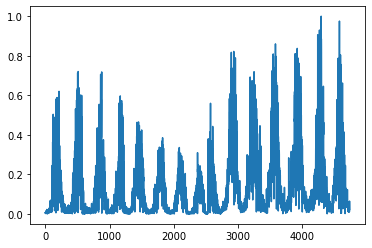

In [ ]:
plt.plot(ytrue)

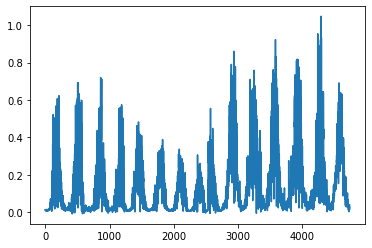

In [ ]:
plt.plot(preds[0])

In [ ]:
for n, p in enumerate(preds):
    mse = mean_squared_error(ytrue, p[:ytrue.shape[0]])
    print(f"Error {n + 1} day forecast = {mse}")

Error 1 day forecast = 0.0012637464234858745
Error 2 day forecast = 0.013578728395692748
Error 3 day forecast = 0.01569759256129491
Error 4 day forecast = 0.016089730913394617
Error 5 day forecast = 0.01658537970889034
Error 6 day forecast = 0.01704376470182181
Error 7 day forecast = 0.016809618003895722
Error 8 day forecast = 0.017311227354818513
Error 9 day forecast = 0.017878875341880734
Error 10 day forecast = 0.017552361030958676
Error 11 day forecast = 0.017325968807897395
Error 12 day forecast = 0.01826968043579242
Error 13 day forecast = 0.01783033172992048
Error 14 day forecast = 0.018726256443687653
Error 15 day forecast = 0.018574615753010885
Error 16 day forecast = 0.018571025513615804
Error 17 day forecast = 0.019285196280174072
Error 18 day forecast = 0.01941374133928571
Error 19 day forecast = 0.019907747046964876
Error 20 day forecast = 0.020501636193277138
Error 21 day forecast = 0.020862581247393652
Error 22 day forecast = 0.02066549575513394
Error 23 day forecast = 0

In [ ]:
print("\n-----------------------------------------------End of process-----------------------------------------------")


-----------------------------------------------End of process-----------------------------------------------
